# Importing libraries

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.patches as mpatches

# Loading dataset


In [15]:
df = pd.read_csv('data/diabetes_prediction_dataset.csv')

In [3]:
df = pd.read_csv('data/diabetes_prediction_dataset.csv')
df.rename(columns={'diabetes': 'target'}, inplace=True)

In [16]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


# Comparing features and data preprocessing

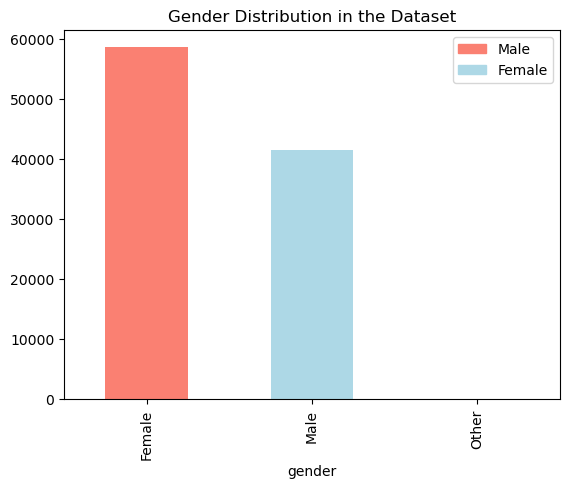

In [21]:
gender_counts = df["gender"].value_counts()
ax = gender_counts.plot(kind="bar", color=["salmon", "lightblue"])

# Customize the plot title
plt.title("Gender Distribution in the Dataset")

# Create custom legend
legend_labels = ["Male", "Female"]
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(["salmon", "lightblue"], legend_labels)]
plt.legend(handles=legend_patches)

# Show the plot
plt.show()


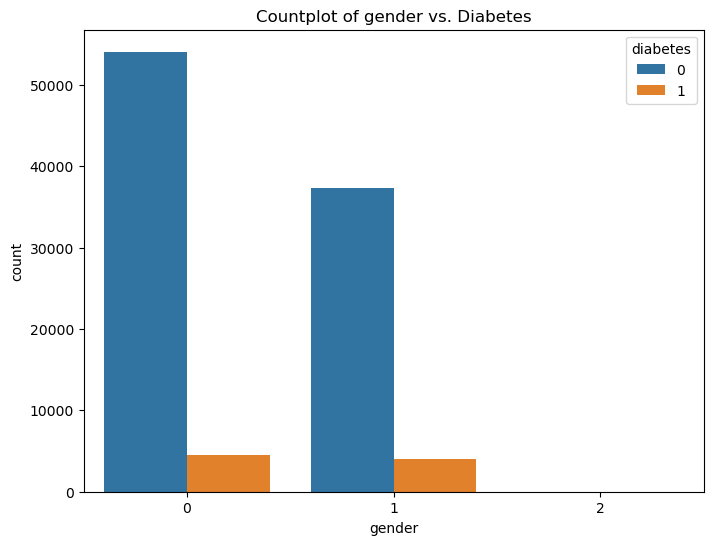

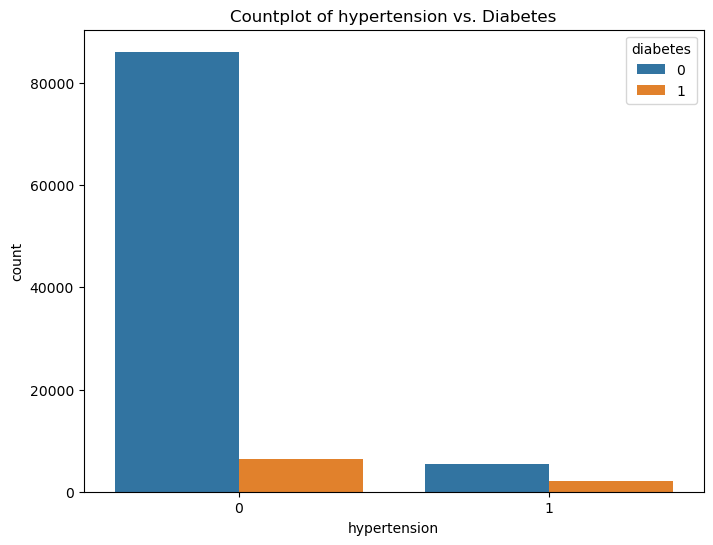

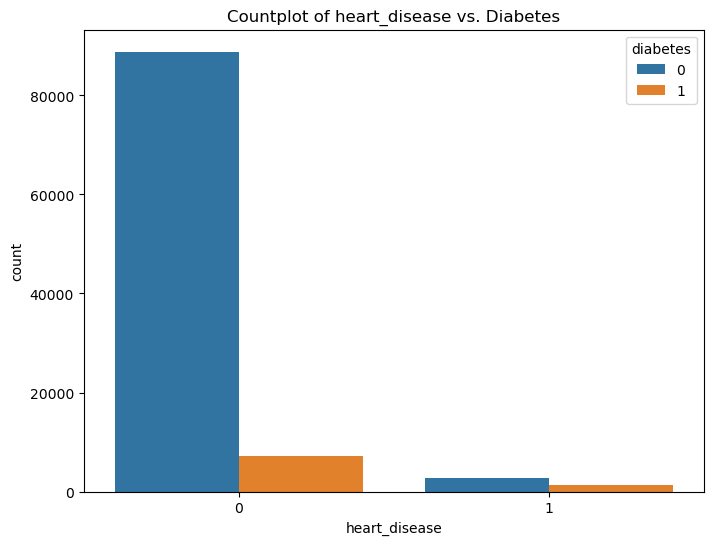

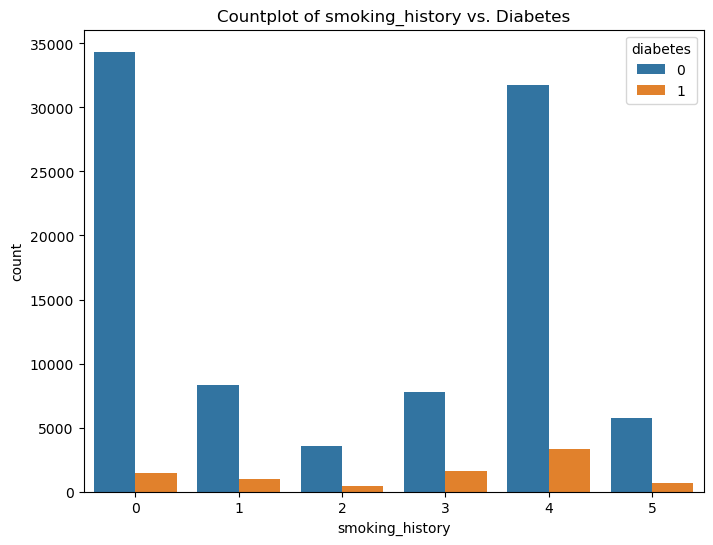

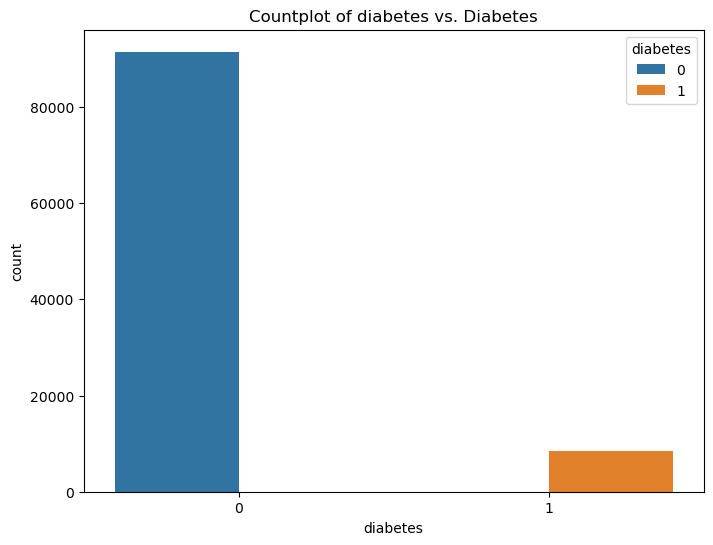

In [23]:
categorical_columns = ['gender', 'hypertension', 'heart_disease', 'smoking_history', 'diabetes']
for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x=col, hue='diabetes')
    plt.title(f'Countplot of {col} vs. Diabetes')
    plt.show()

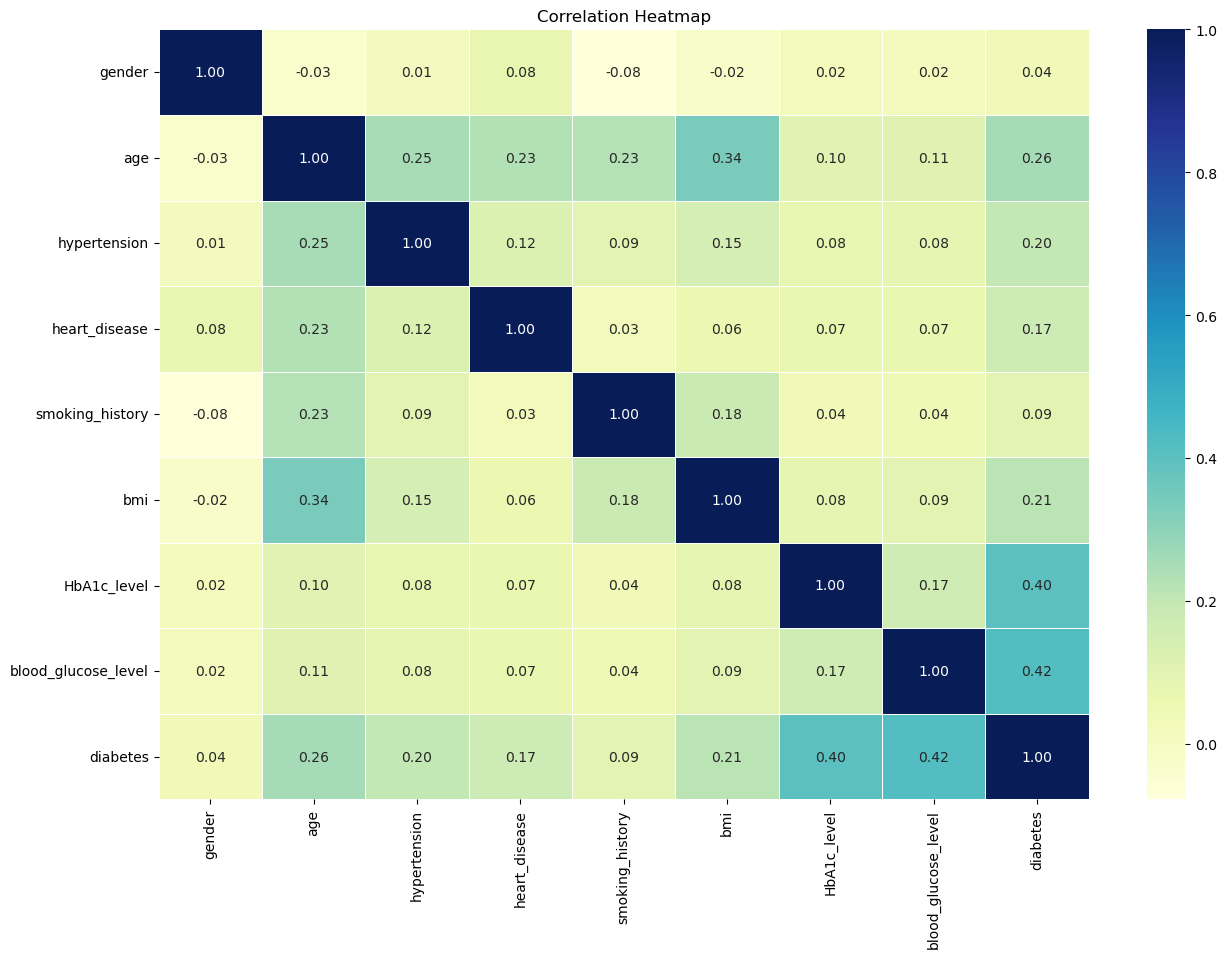

In [22]:
categorical_columns = ['gender', 'smoking_history']  

label_encoder = LabelEncoder()
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

corr_matrix = df.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5, fmt=".2f", cmap="YlGnBu")
plt.title("Correlation Heatmap")
plt.show()


# Model building


In [10]:
X = df.drop("target", axis=1)
y = df["target"]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X.columns.difference(categorical_columns)),
        ('cat', categorical_transformer, categorical_columns)
    ])
models = [
    ("Logistic Regression", LogisticRegression()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42))
]

results = []
for name, model in models:
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results.append((name, accuracy))



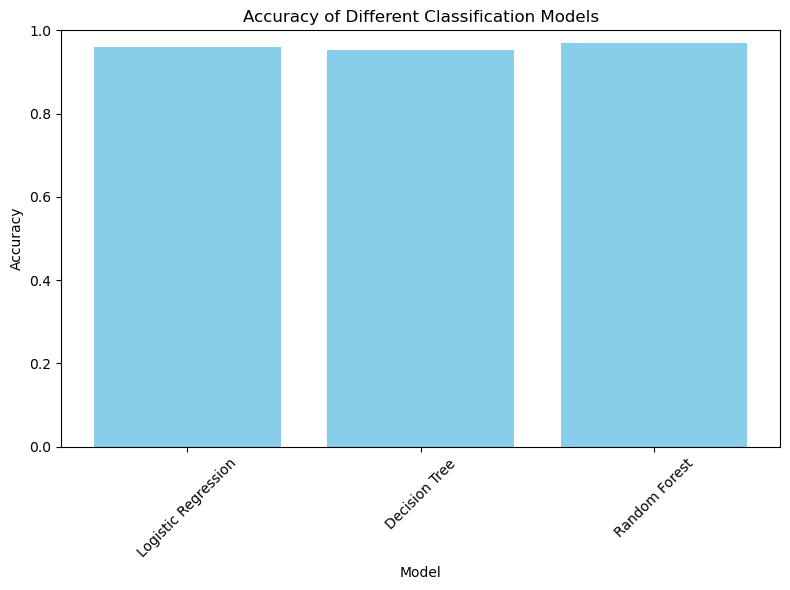

In [13]:
model_names, accuracies = zip(*results)
plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Classification Models')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Tuning by hand


In [14]:
train_scores=[]
test_scores=[]
neighbors=range(1,21)
knn=KNeighborsClassifier()

for i in neighbors:
    knn.set_params(n_neighbors=i)
    knn.fit(X_train,y_train)
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

KeyboardInterrupt: 

Maximum KNN score on the test data: 95.33%


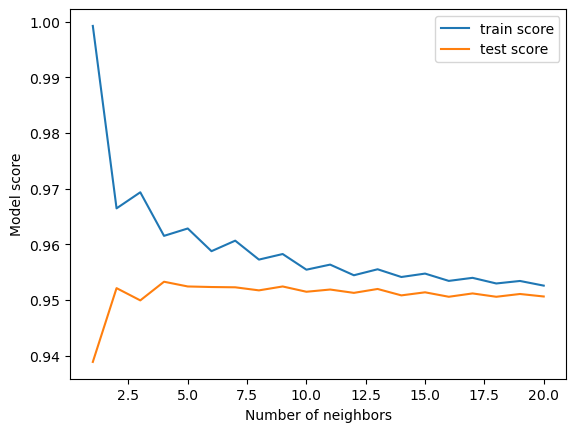

In [ ]:
plt.plot(neighbors, train_scores, label="train score")
plt.plot(neighbors, test_scores, label="test score")
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum KNN score on the test data: {max(test_scores)*100:.2f}%")

# Tuning using RandomizedSearchCV.


In [ ]:
log_reg_grid = {
                'C': [0.001, 0.01, 0.1, 1, 10, 100], 
                'solver': ['liblinear'],                      
                }    

rf_grid = {"n_estimators": np.arange(10, 1000, 50),
            "max_depth": [None, 3, 5, 10],
            "min_samples_split": np.arange(2, 20, 2),
            "min_samples_leaf": np.arange(1, 20, 2)}

In [ ]:
np_random_seed = 42

rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

rs_log_reg.fit(X_train, y_train);

Fitting 5 folds for each of 6 candidates, totalling 30 fits


g:\anaconda\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [ ]:
rs_log_reg.best_params_


{'solver': 'liblinear', 'C': 100}

In [ ]:
rs_log_reg.score(X_test, y_test)


0.9587

In [ ]:
np_random_seed = 42

rs_rf = RandomizedSearchCV(RandomForestClassifier(),  
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True,
                           random_state=np_random_seed)  
                                            
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   random_state=42, verbose=True)

In [ ]:
rs_rf.best_params_

{'n_estimators': 310,
 'min_samples_split': 12,
 'min_samples_leaf': 5,
 'max_depth': None}

In [ ]:
rs_rf.score(X_test, y_test)

0.9724

# Tuning using GridSearchCV
Similar to RandomizedSearchCV, GridSearchCV is used for hyperparameter tuning. It performs an exhaustive search over a specified hyperparameter grid. We again display the best hyperparameters found for Logistic Regression and calculate their accuracy score on the test set.


In [ ]:
log_reg_grid = {"C": np.logspace(-4, 4, 30),
                "solver": ["liblinear"]}

gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)

gs_log_reg.fit(X_train, y_train);      

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [ ]:
gs_log_reg.best_params_

{'C': 17.433288221999874, 'solver': 'liblinear'}

In [ ]:
gs_log_reg.score(X_test, y_test)


0.95865

In [ ]:
log_reg_grid = {
    "C": np.logspace(-4, 4, 30),
    "solver": ["liblinear"],
    "penalty": ["l1", "l2"],
    "max_iter": [100, 200, 300],
    "fit_intercept": [True, False],
    "class_weight": [None, "balanced"],
}

gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)

gs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


g:\anaconda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
g:\anaconda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
g:\anaconda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
g:\anaconda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
g:\anaconda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
g:\anaconda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
g:\anaconda\Lib\site-packages\sklearn\svm\_bas

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                         'class_weight': [None, 'balanced'],
                         'fit_intercept': [True, False],
                         'max_iter': [100, 200, 300], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             verbose=True)

In [ ]:
gs_log_reg.best_params_


{'C': 0.38566204211634725,
 'class_weight': None,
 'fit_intercept': True,
 'max_iter': 300,
 'penalty': 'l1',
 'solver': 'liblinear'}

In [ ]:
gs_log_reg.score(X_test, y_test)


0.9587

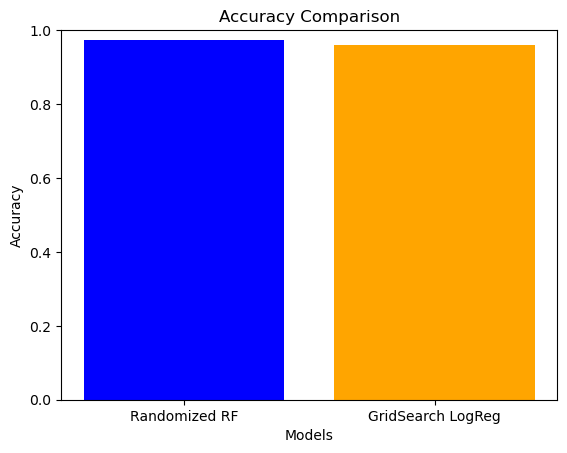

In [ ]:
accuracy_scores = [rs_rf.score(X_test, y_test),
                   gs_log_reg.score(X_test, y_test)]

model_names = ["Randomized RF", "GridSearch LogReg"]

plt.bar(model_names, accuracy_scores, color=['blue', 'orange'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.ylim(0, 1)
plt.show()

In [ ]:
rs_rf.score(X_test, y_test)

0.9724

# Evaluating our model
We evaluate the Random Forest model's performance by generating a Receiver Operating Characteristic (ROC) curve and calculating the Area Under the Curve (AUC). The ROC curve visualizes the trade-off between true positive rate and false positive rate. We plot the ROC curve and display the AUC value.

Additionally, we generate a confusion matrix and a heatmap to visualize the model's performance in terms of true positive, true negative, false positive, and false negative predictions.

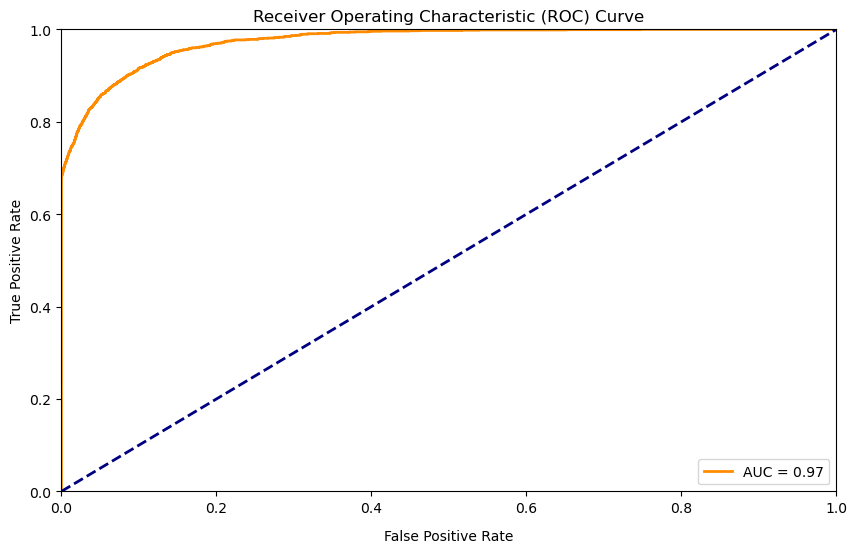

In [ ]:
from sklearn.metrics import roc_curve, auc


y_pred_prob = rs_rf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

plt.xlabel('False Positive Rate', labelpad=10)  

plt.legend(loc='lower right')
plt.show()

In [ ]:
Rf = RandomForestClassifier(n_estimators = 310, min_samples_split = 12, min_samples_leaf = 5,  max_depth = None)
Rf.fit(X_train, y_train)
Rf_pred = Rf.predict(X_test)
conf_mat = confusion_matrix(y_test, Rf_pred)
print(conf_mat)

[[18286     6]
 [  547  1161]]


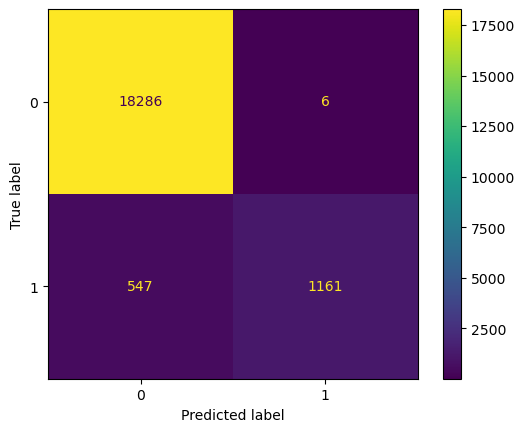

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, Rf_pred)
plt.show()

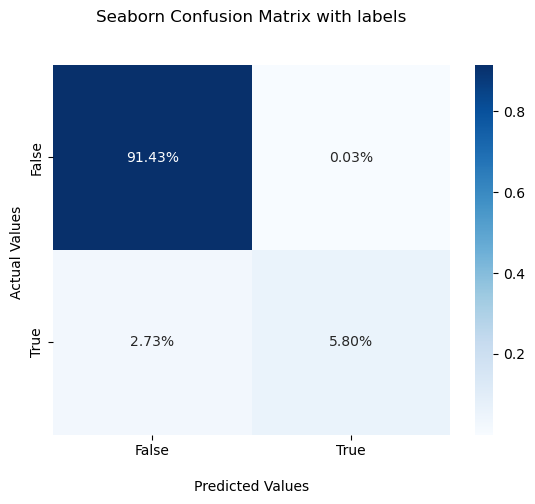

In [ ]:
ax = sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

In [ ]:
rs_rf.best_params_


{'n_estimators': 310,
 'min_samples_split': 12,
 'min_samples_leaf': 5,
 'max_depth': None}

In [ ]:
clf = RandomForestClassifier(n_estimators=310,
                             min_samples_split=12,
                             min_samples_leaf=5,
                             max_depth=None)

In [ ]:
cv_acc=cross_val_score(clf,X,y,cv=5,scoring="accuracy")
cv_acc=np.mean(cv_acc)
cv_acc

0.9720000000000001

In [ ]:
cv_precision= cross_val_score(clf, X, y, cv=5, scoring='precision')
cv_precision=np.mean(cv_precision)
cv_precision

0.9919073413318215

In [ ]:
cv_recall= cross_val_score(clf, X, y, cv=5, scoring="recall")
cv_recall=np.mean(cv_recall)
cv_recall

0.6755294117647059

In [ ]:
cv_f1=cross_val_score(clf,X,y,cv=5,scoring="f1")
cv_f1=np.mean(cv_f1)
cv_f1  

0.8045044488112151

<Axes: title={'center': 'Cross-validated classification metrics'}>

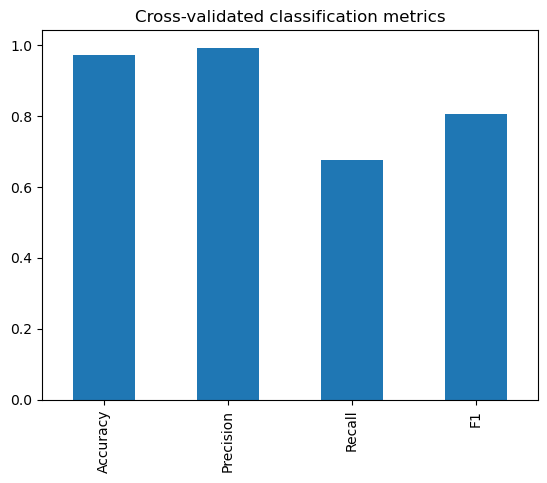

In [ ]:
cv_metrics=pd.DataFrame({"Accuracy":cv_acc,"Precision":cv_precision,"Recall":cv_recall,"F1":cv_f1},index=[0])
cv_metrics.T.plot.bar(title="Cross-validated classification metrics",legend=False)

# Important features
We analyze the feature importances of the Random Forest model. Feature importance indicates the contribution of each feature to the model's predictions. We create a bar chart to display the feature importances, helping us identify which features are most influential in predicting diabetes.

In [ ]:
clf = RandomForestClassifier(n_estimators=310,
                             min_samples_split=12,
                             min_samples_leaf=5,
                             max_depth=None)
clf.fit(X_train, y_train)


RandomForestClassifier(min_samples_leaf=5, min_samples_split=12,
                       n_estimators=310)

In [ ]:
feature_importances = clf.feature_importances_


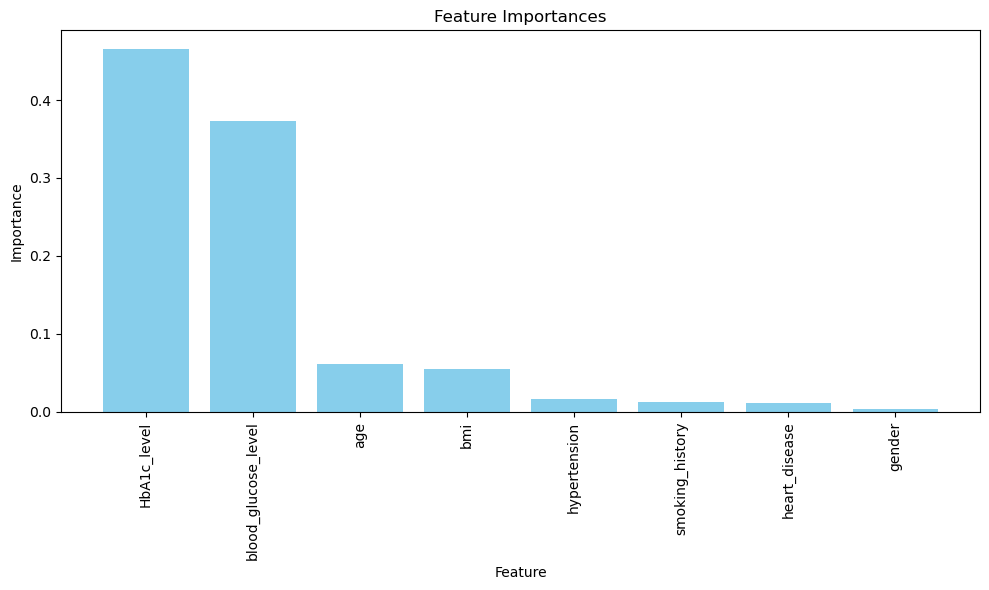

In [ ]:
feature_names = list(X_train.columns)
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [ ]:
import joblib

model = RandomForestClassifier(n_estimators=310, min_samples_split=12, min_samples_leaf=5, max_depth=None)
model.fit(X_train, y_train)

# Save the model to a file
joblib.dump(model, 'model.pkl')


['model.pkl']

In [ ]:
pip install flask

Note: you may need to restart the kernel to use updated packages.
